In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
import statsmodels.api as sm

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()
    
def plot_linear_regression(column, linear_a, linear_b, linear_a_half, linear_b_half):
    plt.figure(figsize=(10, 6))
    plt.scatter(column.index, column, label='Original Values')
    plt.plot(column.index, linear_a * column.index + linear_b, color='red', label='Linear Regression')
    plt.plot(column.index, linear_a_half * column.index + linear_b_half, color='green', label='Recent Linear Regression')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Original Values vs. Linear Regression vs. Recent Linear Regression')
    plt.grid(True)
    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [5]:
# Polynomial Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(1, 4):
            value = column.at[i]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = i - 1
                end_first = next_valid_index(column, i)
                linear_a = (column.at[end_first] - column.at[i - 1])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            x = size - 4 + i
            value = column.at[x]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, x)
                end_last = next_valid_index(column, x)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[x] = linear_a*x + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column

def extract_valid_values(column):
    valid_values = []
    valid_indexes = []
    for index, value in enumerate(column):
        if not pd.isnull(value) and not np.isnan(value):
            valid_values.append(value)
            valid_indexes.append(index)
    extracted_column = pd.Series(
        valid_values,
        index=valid_indexes
    )
    return extracted_column

def linear_regression_first_four_filler(column):
    size = len(column) - 1
    processed_column = extract_valid_values(column)
    mean_valid_values_quarter = processed_column.mean()/4
    mean_valid_values_quarter_upper = processed_column.mean() + mean_valid_values_quarter
    
    model = sm.OLS(processed_column, sm.add_constant(processed_column.index))
    result = model.fit()
    linear_a = result.params[1]
    linear_b = result.params['const']
    half_column = processed_column[:(len(processed_column) // 2)]
    model2 = sm.OLS(half_column, sm.add_constant(half_column.index))
    result2 = model2.fit()
    linear_a_half = result2.params[1]
    linear_b_half = result2.params['const']
    
    for i in range(0,4):
        if pd.isnull(column.at[i]) or np.isnan(column.at[i]):
            projected = ((linear_a*i + linear_b) + (linear_a_half*i + linear_b_half))/2
            if projected < mean_valid_values_quarter:
                column.at[i] = mean_valid_values_quarter
            elif projected > mean_valid_values_quarter_upper:
                column.at[i] = mean_valid_values_quarter_upper
            else:
                column.at[i] = projected
        x = size - 4 + i
        if pd.isnull(column.at[x]) or np.isnan(column.at[x]):
            projected = ((linear_a*i + linear_b) + (linear_a_half*i + linear_b_half))/2
            if projected < mean_valid_values_quarter:
                column.at[x] = mean_valid_values_quarter
            elif projected > mean_valid_values_quarter_upper:
                column.at[x] = mean_valid_values_quarter_upper
            else:
                column.at[x] = projected
    plot_linear_regression(column, linear_a, linear_b, linear_a_half, linear_b_half)
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [6]:
def insert_empty_rows(df, init, end):
    blank_years = list(range(init, end))
    empty_rows = [pd.DataFrame({'Year': [year] + [''] * (df.shape[1] - 1)}) for year in blank_years]
    df = pd.concat([pd.DataFrame({'Year': [year]}) for year in years_to_insert] + [df], ignore_index=True)
    df = df.sort_values(by='Year').reset_index(drop=True)

    return df

In [7]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = linear_regression_first_four_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 3) #3 meses
                df[col] = polynomial_filler(df[col])
                df[col] = df[col].apply(replace_negative_with_float_zeros)
            i += 1
        return df

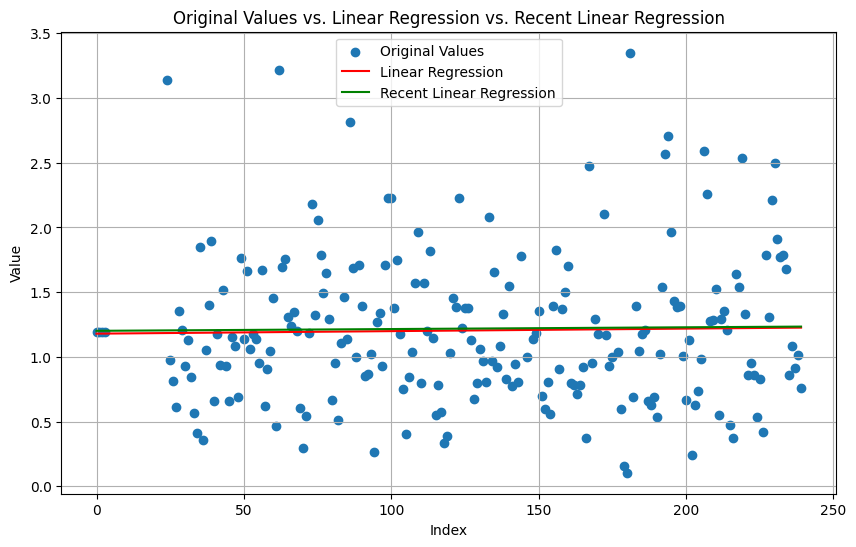

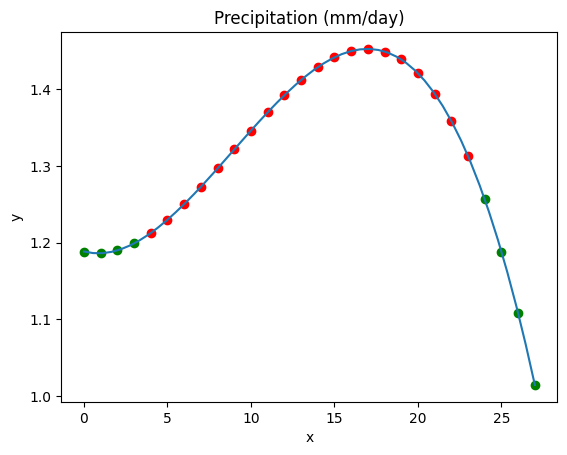

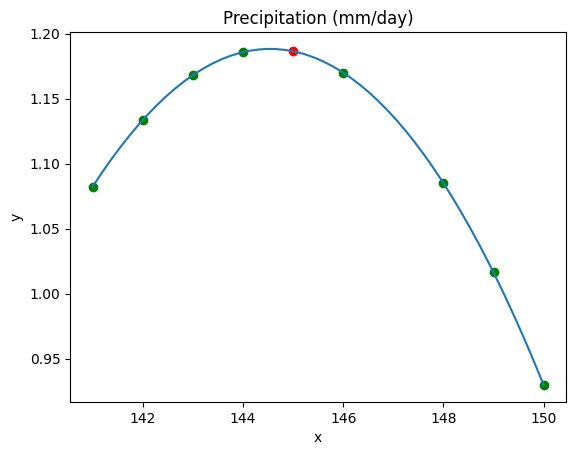

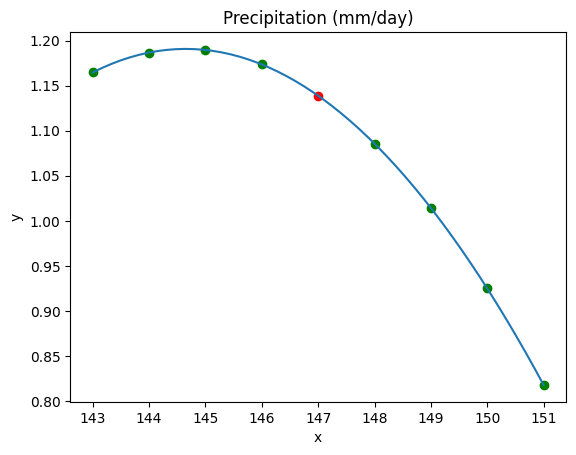

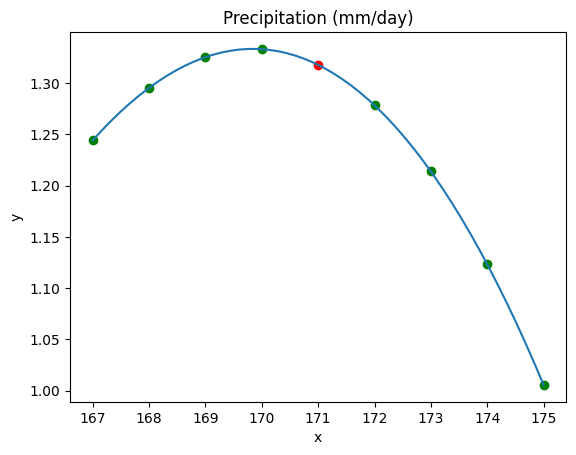

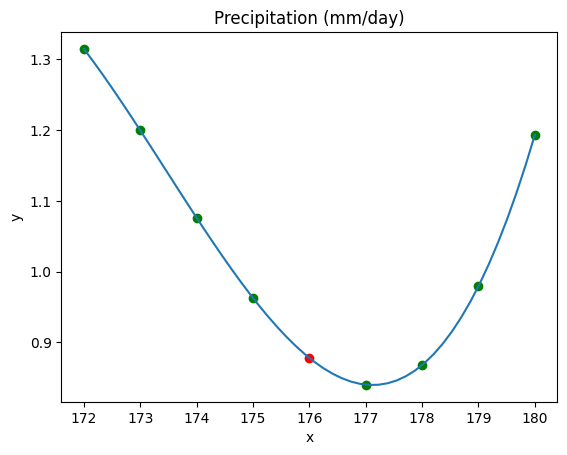

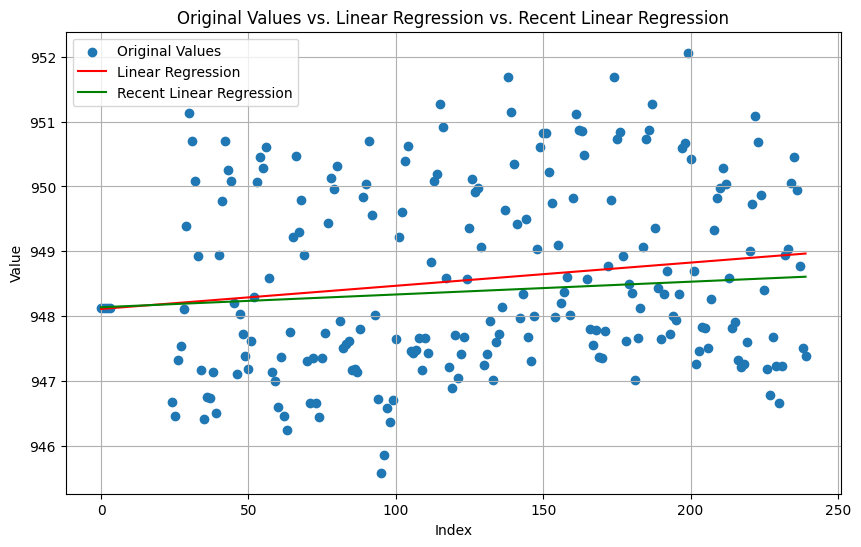

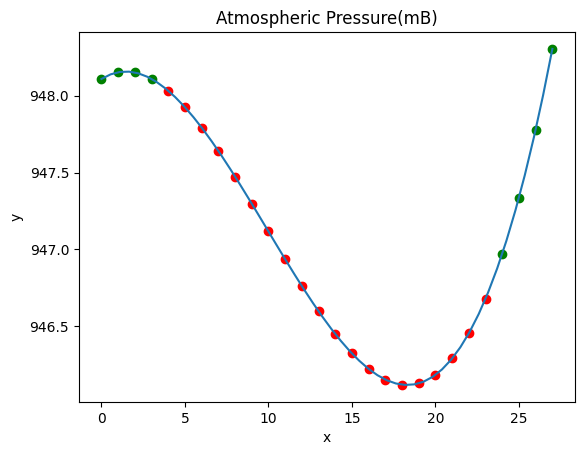

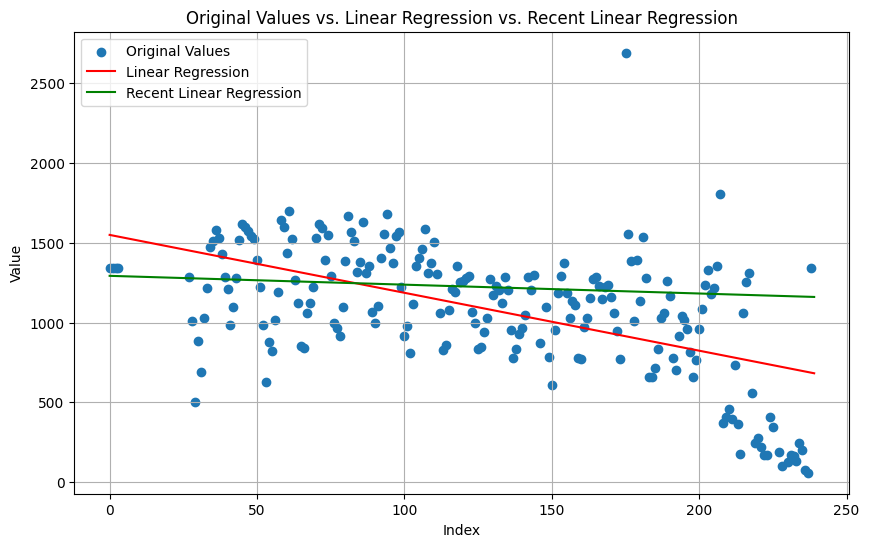

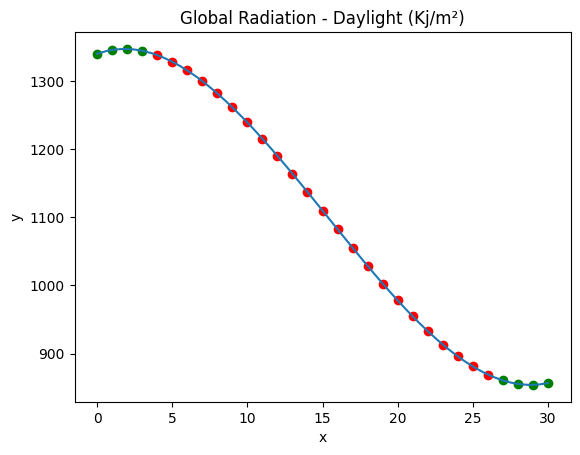

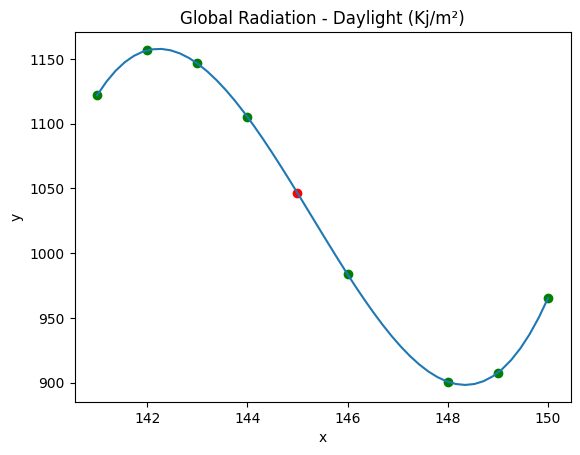

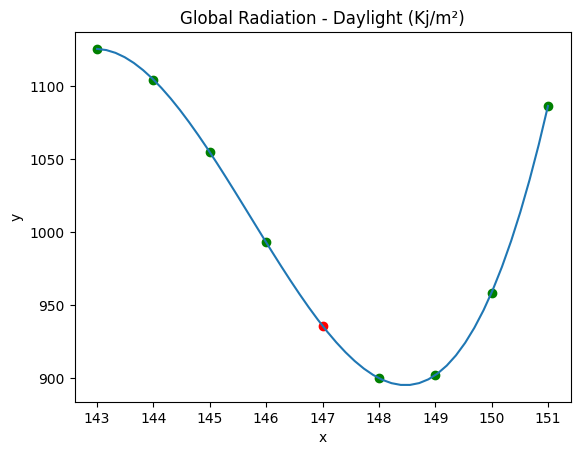

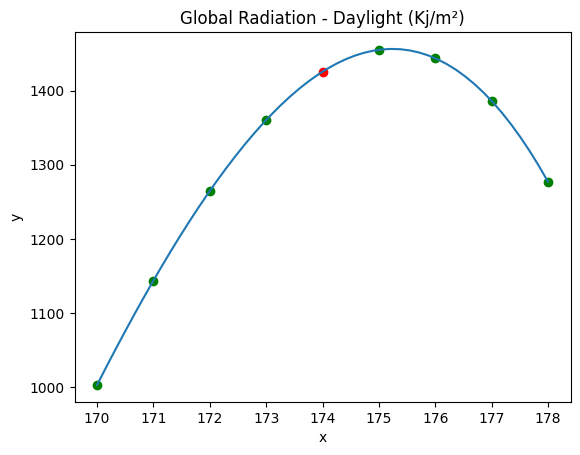

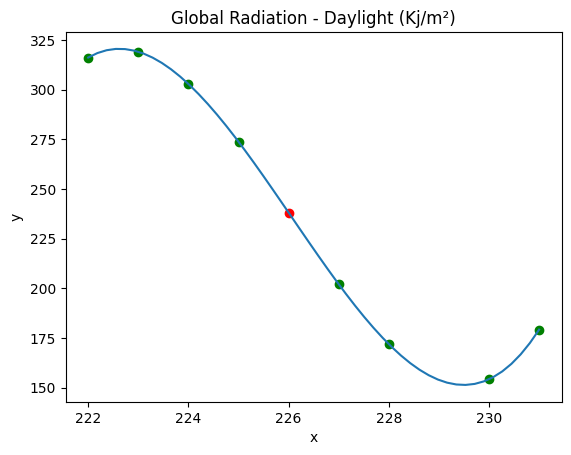

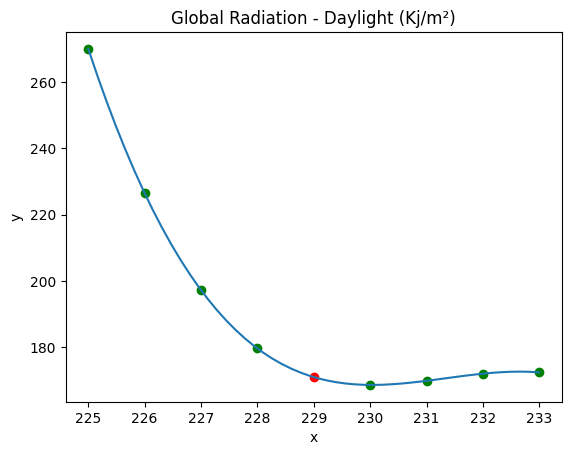

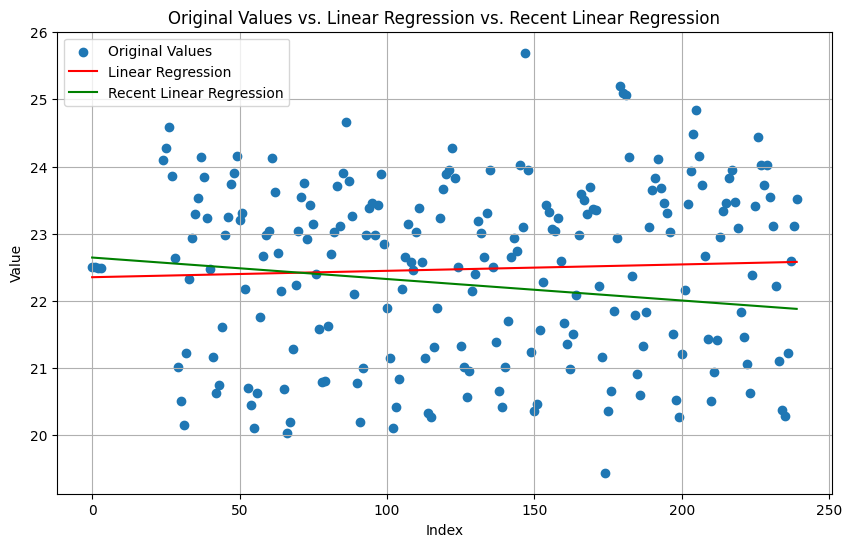

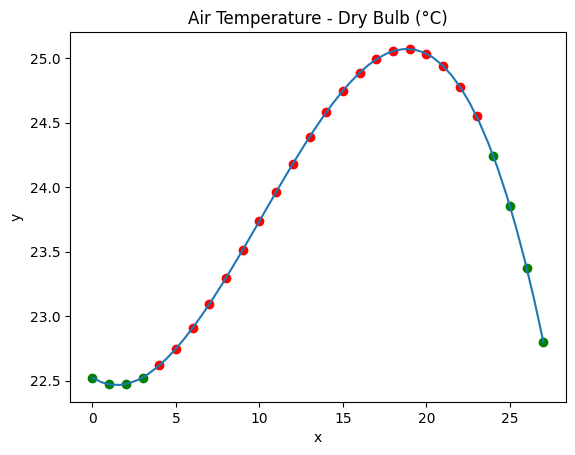

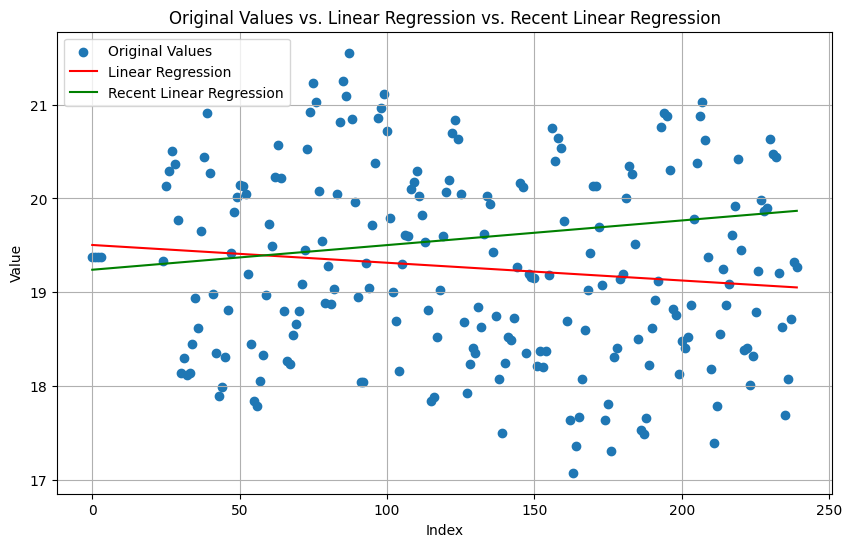

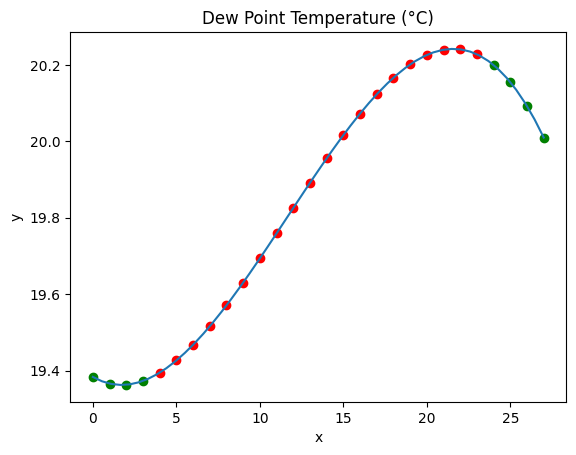

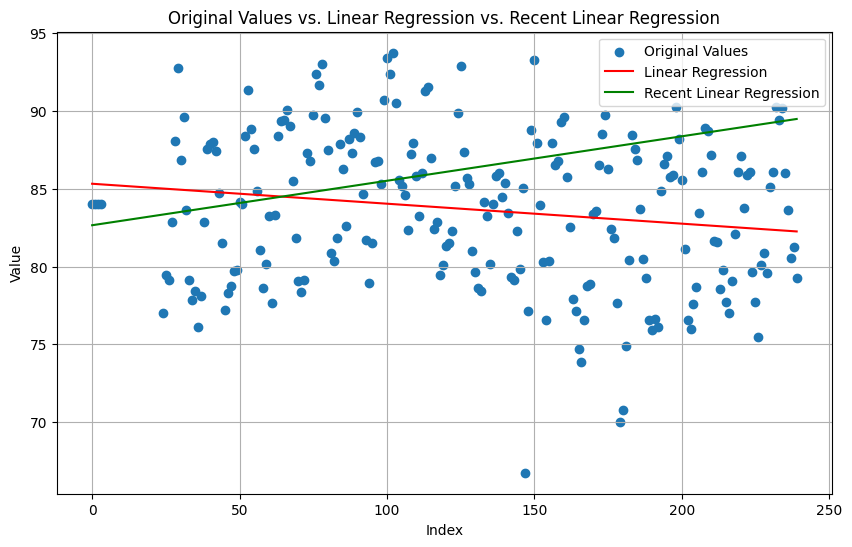

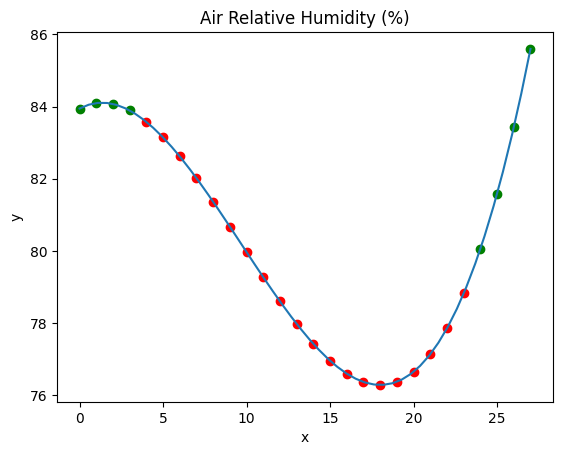

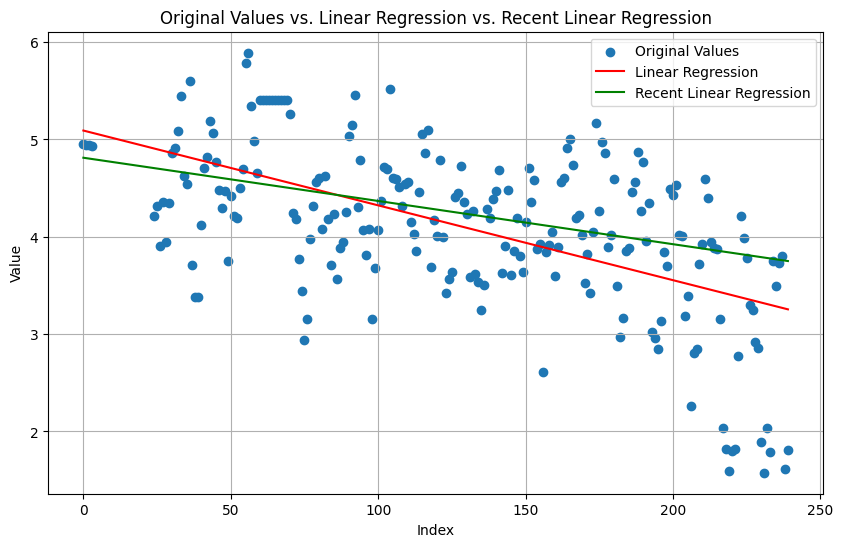

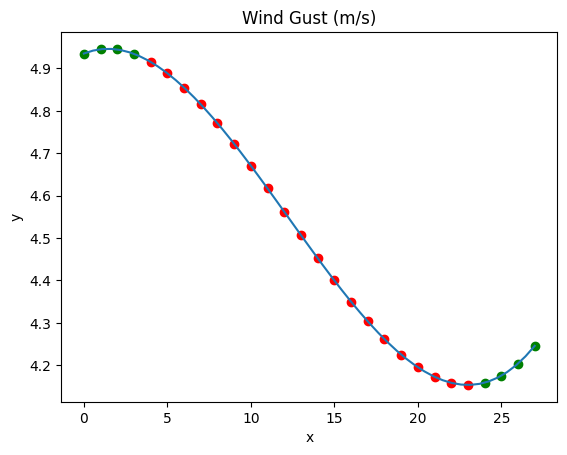

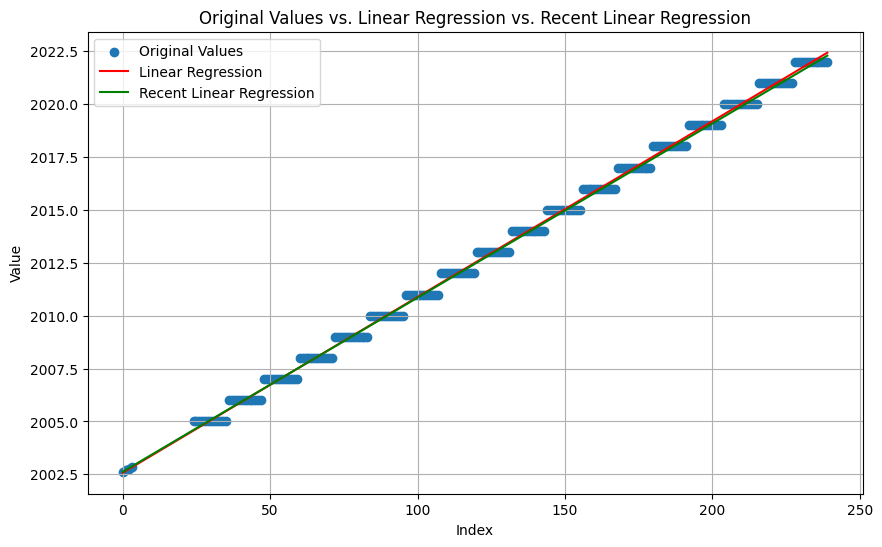

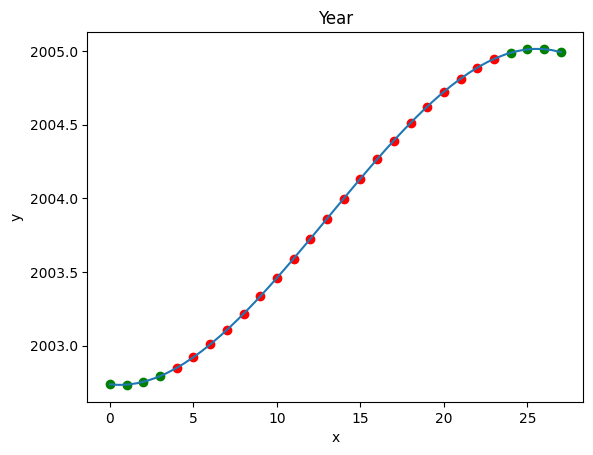

,Ano,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year
0,2003,1.190368,948.129859,1343.725535,22.497513,19.371613,84.002026,4.942143,2002.722096
1,2003,1.190430,948.130898,1343.725535,22.497092,19.371751,84.004982,4.939870,2002.753106
2,2003,1.190466,948.131504,1343.725535,22.496846,19.371831,84.006706,4.938543,2002.771196
3,2003,1.190470,948.131569,1343.725535,22.496820,19.371840,84.006891,4.938401,2002.773134
4,2003,1.212656,948.032498,1337.766989,22.616890,19.394367,83.575985,4.915516,2002.849320
...,...,...,...,...,...,...,...,...,...
235,2022,1.201229,949.160060,311.814483,21.701965,18.705257,84.493745,3.040558,2021.980331
236,2022,1.121888,948.762712,352.255801,22.148149,18.829599,83.138667,2.865656,2021.986821
237,2022,1.060573,948.492322,444.902027,22.420311,18.931075,82.430549,2.726301,2021.989698
238,2022,1.031293,948.261053,613.174462,22.580160,19.009295,82.117924,2.410941,2021.991370


In [8]:
df = read_csv_replace_missing_by_polynomial('paraiba_variacao_climatica.csv', 0, 1)
df.rename(columns={'Date': 'Ano'}, inplace=True)
df['Ano'] = df['Ano'].str[:4].astype(int)
df.drop(columns='State', inplace=True)
df

In [9]:
import re

df_indexed = df.set_index('Ano')

def correct_index(df):
    new_index = []
    for i, index_value in enumerate(df.index):
        new_index.append(f"{index_value}-{i % 12 + 1}")
    df.index = new_index
    return df

df_indexed = correct_index(df_indexed)
df_indexed = df_indexed.drop('Year', axis=1)
df_indexed

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
2003-1,1.190368,948.129859,1343.725535,22.497513,19.371613,84.002026,4.942143
2003-2,1.190430,948.130898,1343.725535,22.497092,19.371751,84.004982,4.939870
2003-3,1.190466,948.131504,1343.725535,22.496846,19.371831,84.006706,4.938543
2003-4,1.190470,948.131569,1343.725535,22.496820,19.371840,84.006891,4.938401
2003-5,1.212656,948.032498,1337.766989,22.616890,19.394367,83.575985,4.915516
...,...,...,...,...,...,...,...
2022-8,1.201229,949.160060,311.814483,21.701965,18.705257,84.493745,3.040558
2022-9,1.121888,948.762712,352.255801,22.148149,18.829599,83.138667,2.865656
2022-10,1.060573,948.492322,444.902027,22.420311,18.931075,82.430549,2.726301
2022-11,1.031293,948.261053,613.174462,22.580160,19.009295,82.117924,2.410941


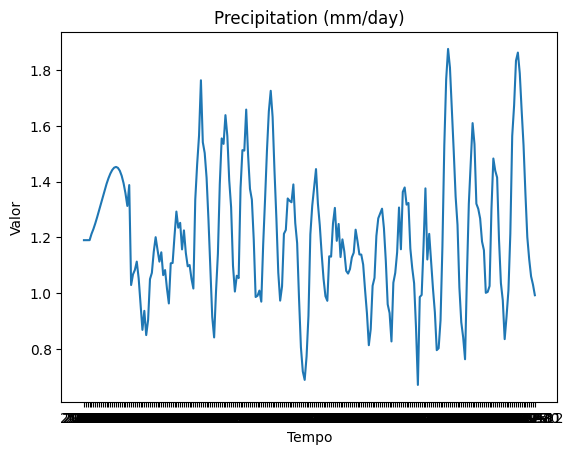

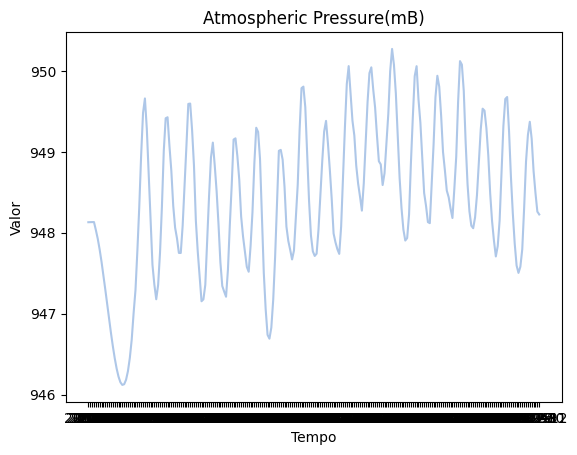

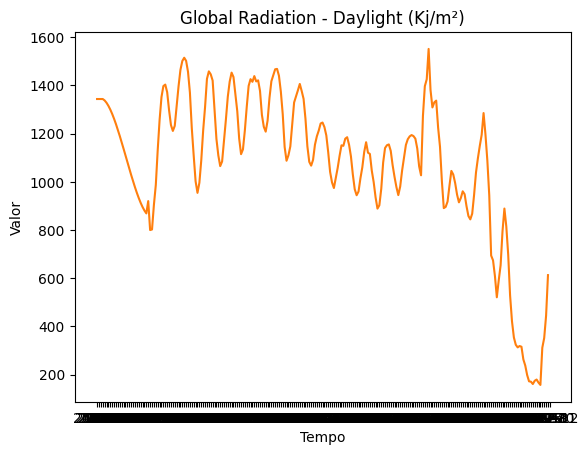

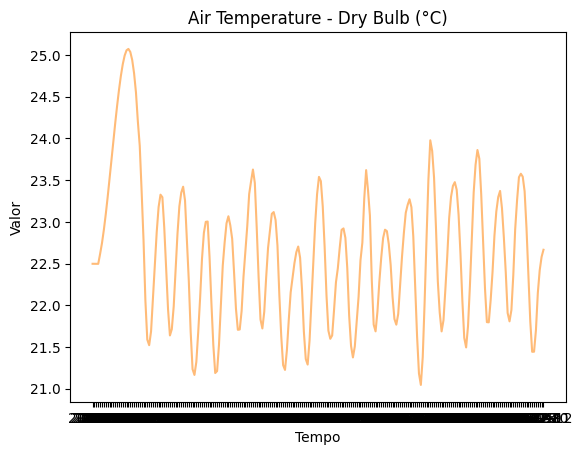

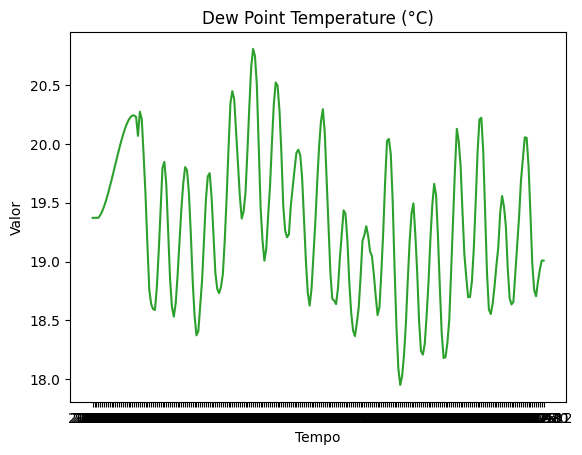

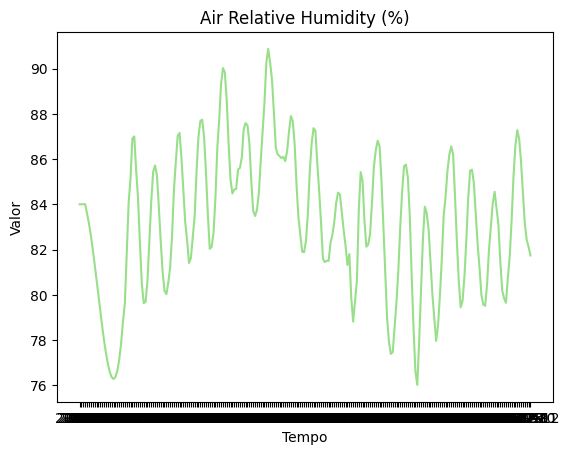

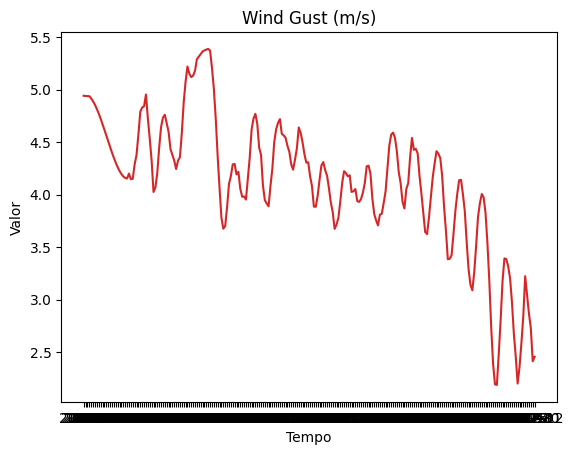

In [10]:
plot_columns(df_indexed)

In [11]:
df_indexed.to_csv('2003_mo_meteo.csv')

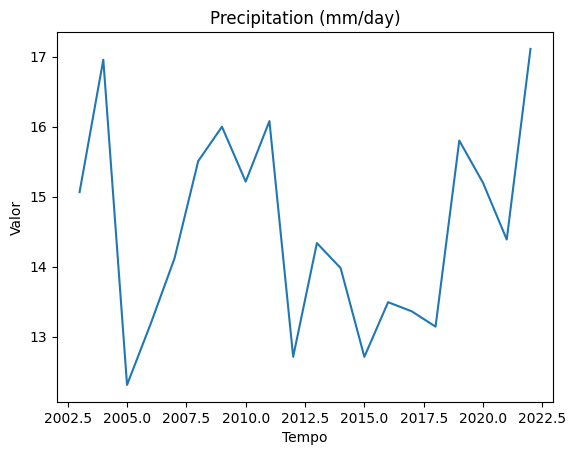

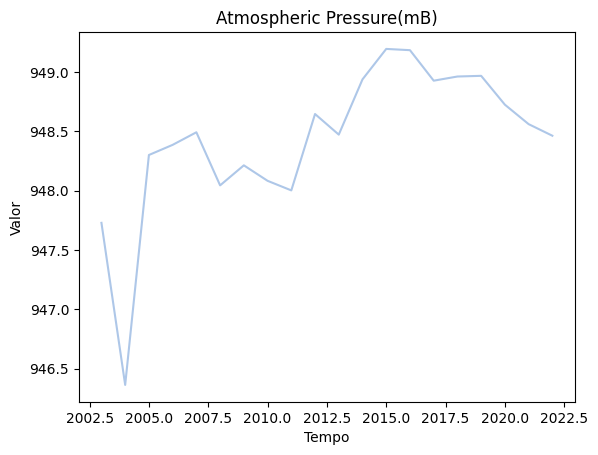

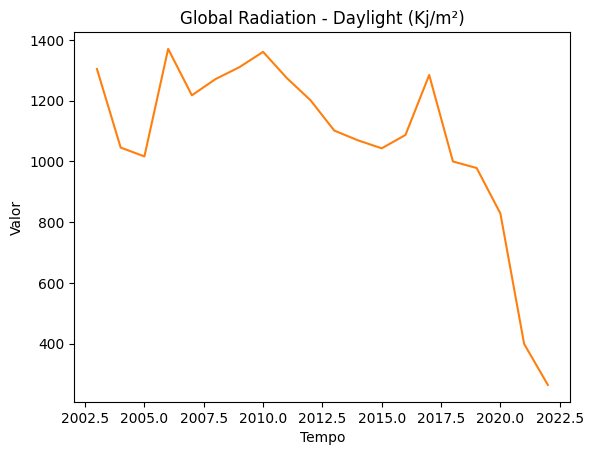

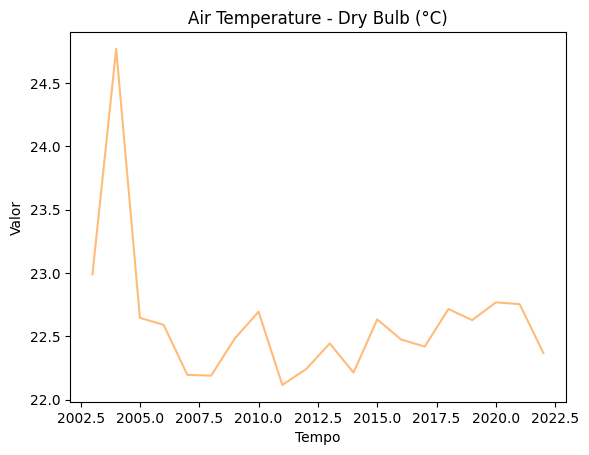

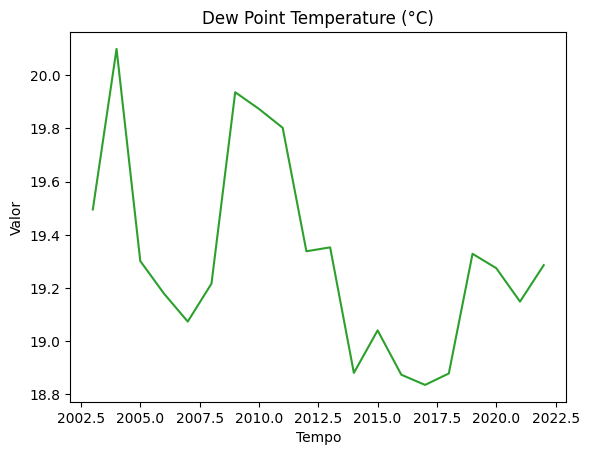

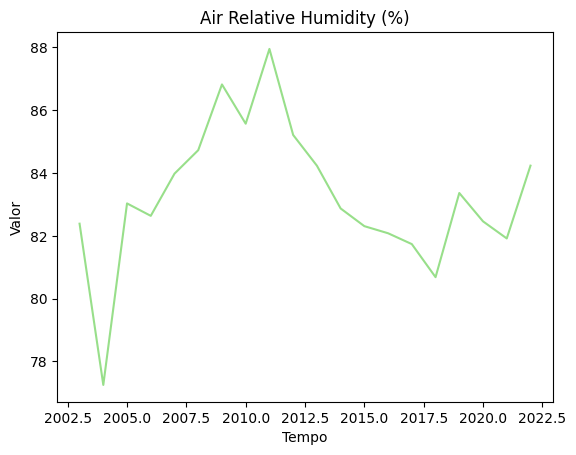

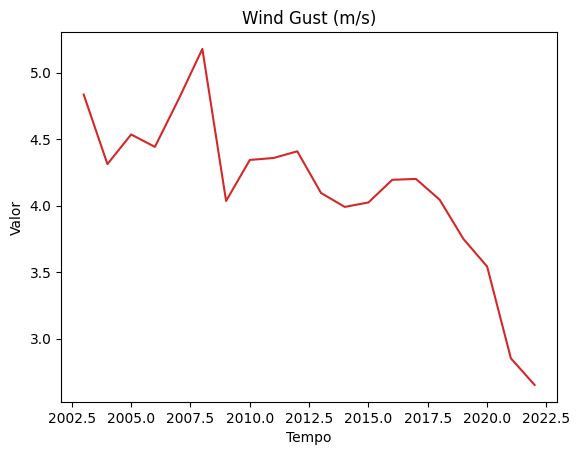

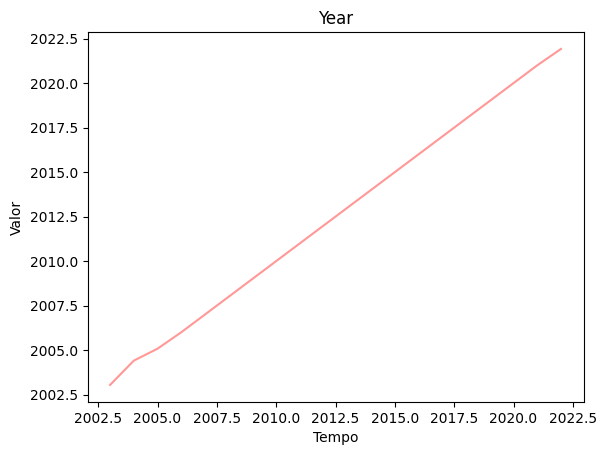

In [12]:
df_year = df.copy()
df_year.set_index('Ano', inplace=True)
df_year = df_year.groupby('Ano').mean()
df_year['Precipitation (mm/day)'] = df_year['Precipitation (mm/day)'] * 12
plot_columns(df_year)

In [13]:
df_2003 = df_year[df_year.index >= 2003]
df_2003

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year
Ano,,,,,,,,
2003,15.062680,947.728143,1304.331793,22.988616,19.495313,82.386995,4.834560,2003.042099
2004,16.954663,946.362499,1045.598810,24.767736,20.099020,77.252435,4.311895,2004.406025
2005,12.308516,948.299764,1016.537814,22.645449,19.301366,83.032107,4.534741,2005.078474
2006,13.185083,948.385204,1370.375636,22.590337,19.178846,82.636511,4.441341,2006.000676
2007,14.115801,948.491255,1217.673523,22.195313,19.073748,83.979655,4.799447,2007.000006
2008,15.506655,948.043795,1271.242170,22.189210,19.216484,84.727548,5.177698,2008.000000
2009,15.996882,948.212676,1310.142398,22.483025,19.936220,86.820992,4.035074,2009.000000
2010,15.213057,948.082227,1360.710986,22.693488,19.873451,85.570680,4.343338,2010.000000
2011,16.077608,948.001510,1274.558537,22.116113,19.802424,87.951878,4.357889,2011.000000


In [14]:
df_2003.to_csv('2003_01_meteo.csv', index=True)

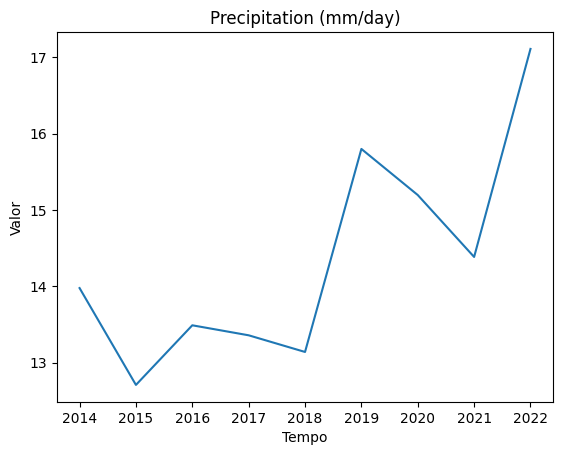

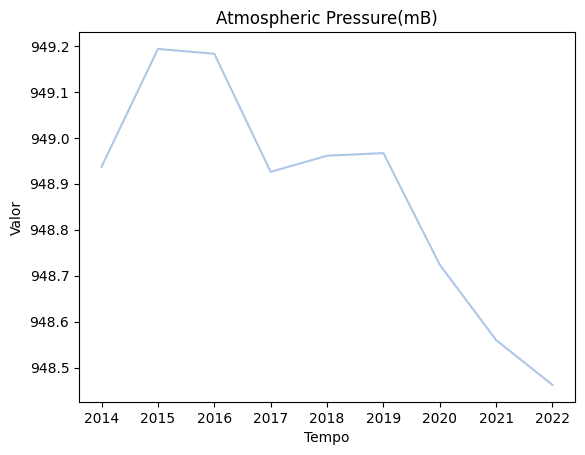

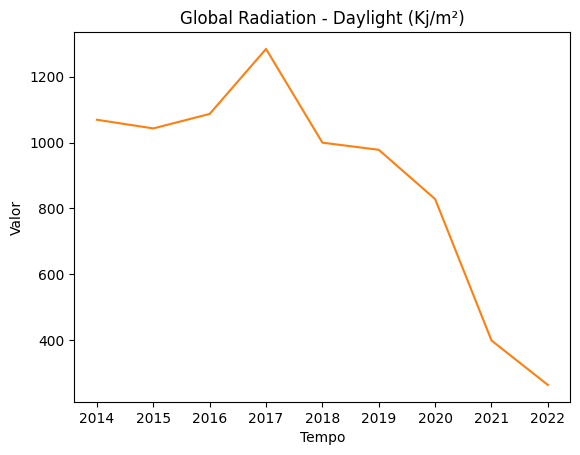

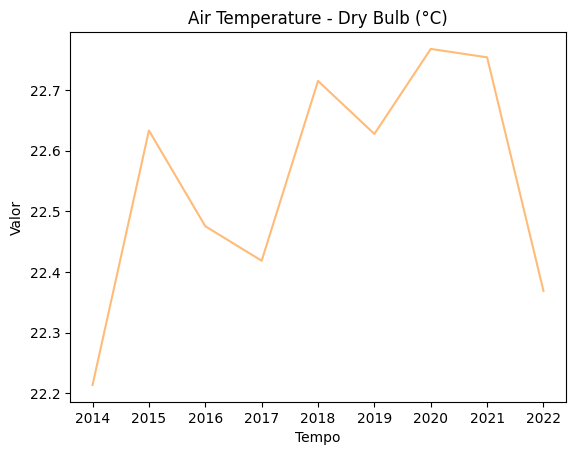

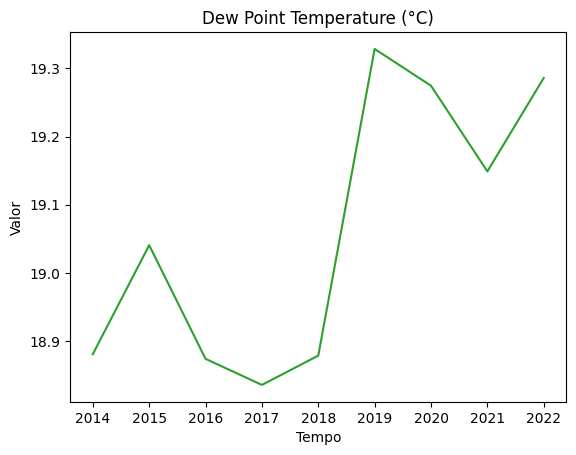

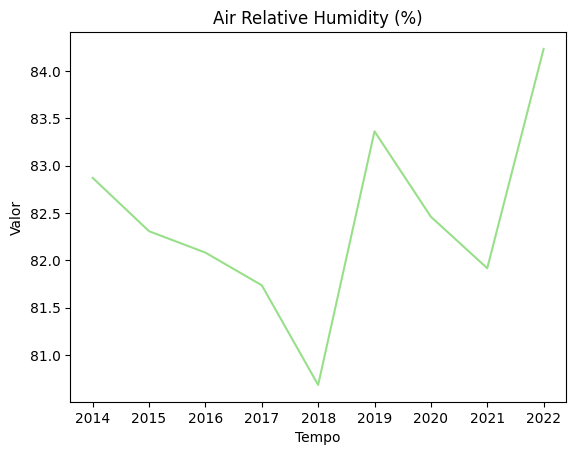

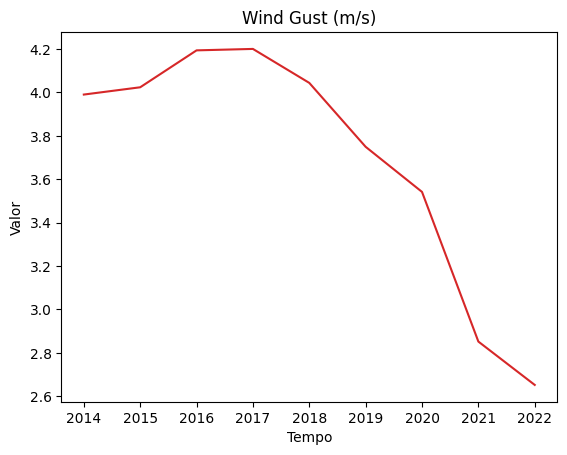

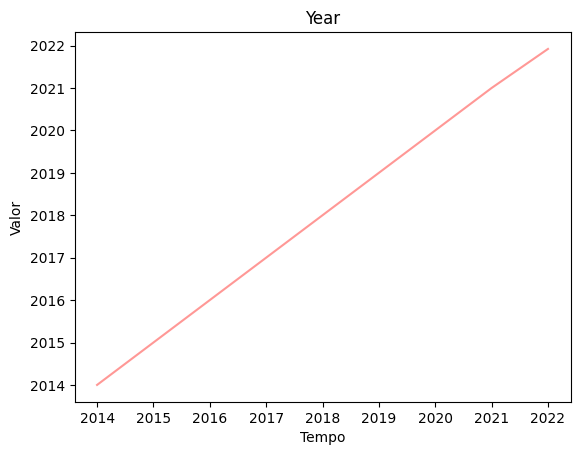

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year
Ano,,,,,,,,
2014,13.977728,948.937020,1069.446981,22.213564,18.880720,82.871623,3.990311,2014.000000
2015,12.709761,949.193527,1043.134029,22.633073,19.040609,82.308047,4.023857,2015.000000
2016,13.490429,949.182967,1087.166033,22.475216,18.873826,82.081846,4.193991,2016.000000
2017,13.359404,948.925930,1284.532195,22.418319,18.835547,81.736584,4.200615,2017.000000
2018,13.141298,948.961050,999.874020,22.714823,18.878560,80.683549,4.044093,2018.000000
2019,15.799274,948.966770,978.287339,22.627369,19.328640,83.363968,3.749533,2019.000000
2020,15.195915,948.723691,828.615267,22.767592,19.274598,82.460936,3.541730,2020.000000
2021,14.385302,948.559802,399.269055,22.753721,19.148906,81.916935,2.852093,2021.000000
2022,17.108799,948.462164,264.251166,22.368491,19.285945,84.234634,2.652324,2021.920844


In [15]:
df_2014 = df_year[df_year.index >= 2014]
plot_columns(df_2014)
df_2014

In [16]:
df_2014.to_csv('2014_01_meteo.csv', index=True)

In [17]:
df_2008 = df_year[df_year.index >= 2008]
df_2008

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year
Ano,,,,,,,,
2008,15.506655,948.043795,1271.242170,22.189210,19.216484,84.727548,5.177698,2008.000000
2009,15.996882,948.212676,1310.142398,22.483025,19.936220,86.820992,4.035074,2009.000000
2010,15.213057,948.082227,1360.710986,22.693488,19.873451,85.570680,4.343338,2010.000000
2011,16.077608,948.001510,1274.558537,22.116113,19.802424,87.951878,4.357889,2011.000000
2012,12.710623,948.645043,1201.334525,22.240199,19.338155,85.211774,4.408208,2012.000000
2013,14.335042,948.471422,1101.559633,22.443043,19.352817,84.234075,4.094948,2013.000000
2014,13.977728,948.937020,1069.446981,22.213564,18.880720,82.871623,3.990311,2014.000000
2015,12.709761,949.193527,1043.134029,22.633073,19.040609,82.308047,4.023857,2015.000000
2016,13.490429,949.182967,1087.166033,22.475216,18.873826,82.081846,4.193991,2016.000000


In [18]:
df_2008.to_csv('2008_01_meteo.csv', index=True)